In [1]:
import os

%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt

from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa

""""
Tutorail for moment by moment decoding --> i.e., for each time bin, find strength of representation of
each class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.

Collects best preprocessing and decoder training methods, as I have determined so far.
"""

'"\nTutorail for moment by moment decoding --> i.e., for each time bin, find strength of representation of\neach class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.\n\nCollects best preprocessing and decoder training methods, as I have determined so far.\n'

# Load a dataset

To load and plot a dataset of neural activity across population, in a PopAnal class object.


In [ ]:
if False:
    # Method 1 - load a single DFallPA
    DFallpa = load_handsaved_wrapper()


In [2]:
# Method 1 - load a single DFallPA
# DFallpa = load_handsaved_wrapper(animal="Pancho", date=230623, version="trial", use_time=False)
DFallpa = load_handsaved_wrapper(animal="Diego", date=230630, version="trial", use_time=False)
# DFallpa = load_handsaved_wrapper(animal="Diego", date=240625, version="trial", use_time=True)


In [ ]:
if False:
    # Method 2 - Combine two dfallpa
    animal = "Diego"
    date = 231211
    COMBINE_AREAS = True

    DFallpa1 = load_handsaved_wrapper(animal=animal, date=date, version="trial", combine_areas=COMBINE_AREAS, use_time=False)
    DFallpa2 = load_handsaved_wrapper(animal=animal, date=date, version="stroke", combine_areas=COMBINE_AREAS, use_time=False)
    DFallpa = pd.concat([DFallpa1, DFallpa2]).reset_index(drop=True)


### Keep just a single region, for quicker testing of code

In [3]:
bregion = "PMv"
DFallpa = DFallpa[DFallpa["bregion"] == bregion].reset_index(drop=True)

# Preprocessing

In [4]:
from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa


##### Prune to chans that are common across pa for each bregion (intersection of chans)|

In [5]:
dfpa_match_chans_across_pa_each_bregion(DFallpa)

PMv  ...  80
PMv  ...  80
PMv  ...  80
PMv  -- n chans final:  80


##### Removing noisy channels

In [6]:
from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_clean_bad_channels
dfpa_concatbregion_preprocess_clean_bad_channels(DFallpa, PLOT=False)

Keep, for  PMv  ... 80 / 80


##### Sqrt normalization

In [7]:
for pa in DFallpa["pa"]:
    pa.X = pa.X**0.5

### FR Normalization

##### Method 1 - each PA normalize independently

In [ ]:
# from neuralmonkey.classes.population_mult import dfallpa_preprocess_fr_normalization
# # fr_normalization_method = "each_time_bin"
# fr_normalization_method = "across_time_bins"
# plot_savedir = "/tmp"
# dfallpa_preprocess_fr_normalization(DFallpa, fr_normalization_method, plot_savedir)

##### Method 2 - Concat events (for each bregion) and normalize all same way


In [ ]:
# from neuralmonkey.classes.population_mult import dfpa_concat_normalize_fr_split_multbregion
# # fr_normalization_method = "each_time_bin"
# fr_normalization_method = "across_time_bins"
# dfpa_concat_normalize_fr_split_multbregion(DFallpa)


##### Method 3 - concat events (flexible version, only constrianed to have same n chans across PA) [works if have both trial and stroke!]

Running ..  PMv


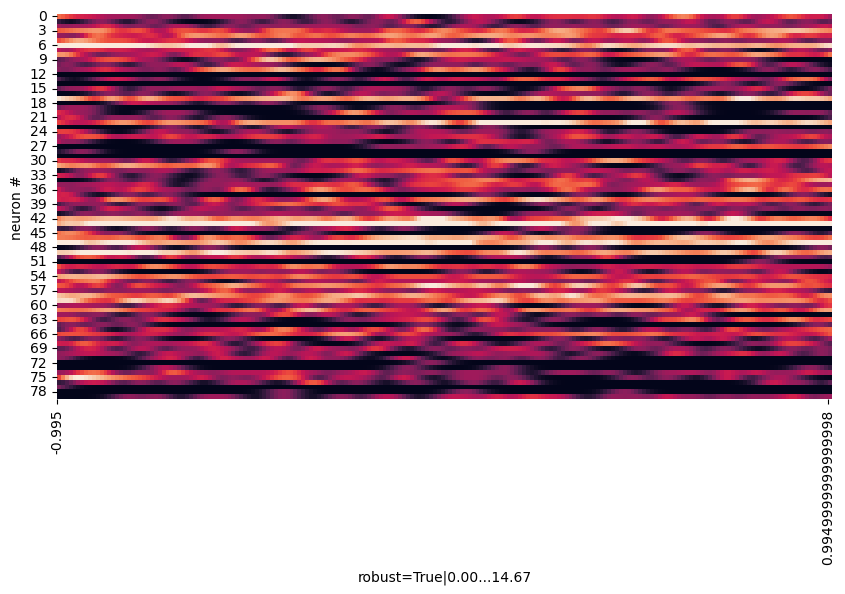

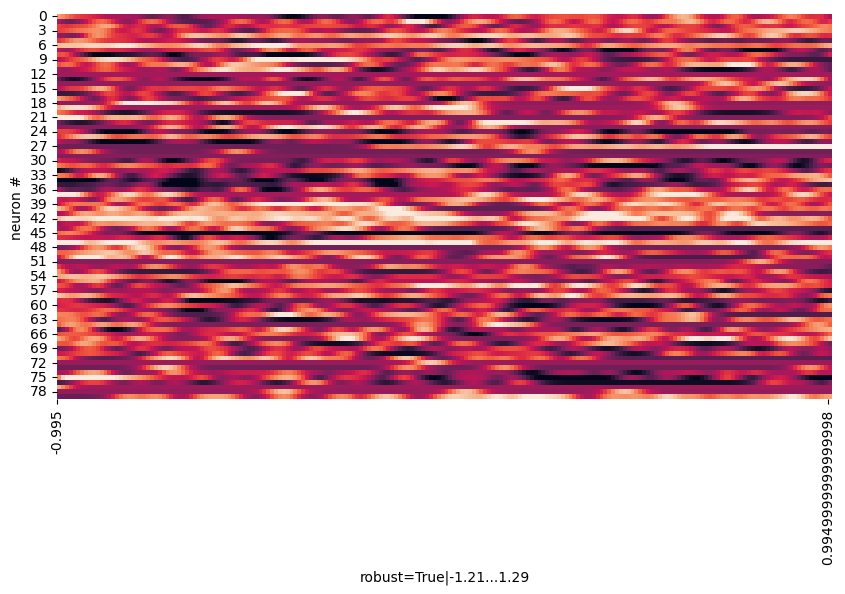

In [8]:
from neuralmonkey.classes.population_mult import dfpa_concat_normalize_fr_split_multbregion_flex
fr_mean_subtract_method = "across_time_bins"
# fr_mean_subtract_method = "each_time_bin"
PLOT=False

pa = DFallpa["pa"].values[0]
pa.plotNeurHeat(0)

dfpa_concat_normalize_fr_split_multbregion_flex(DFallpa, fr_mean_subtract_method, PLOT)

pa = DFallpa["pa"].values[0]
pa.plotNeurHeat(0)

##### Run a single PCA across all events

In [ ]:
# Optionally, prune events, since this will have major impact on the PCs
DFallpa = DFallpa[DFallpa["event"] == "03_samp"].reset_index(drop=True)

In [9]:
from neuralmonkey.classes.population_mult import dfpa_concat_pca_split_multbregion


In [ ]:

# Method 1 -- do PCA on trial-level data
sm_dur=0.1
sm_slide=0.01
npcs_keep_force=15
pca_method = "trials"
dfpa_concat_pca_split_multbregion(DFallpa, sm_dur=sm_dur, sm_slide=sm_slide,
                                      npcs_keep_force=npcs_keep_force,
                                      pca_method = pca_method)

In [ ]:
# Method 2 -- take mean over trials (--> one datapt per level of pcamean_var) and then do pca
sm_dur=0.15
sm_slide=0.01
npcs_keep_force=20
pca_method = "trial_means"
pcamean_var = "seqc_0_shape"
pcamean_vars_grouping = None
dfpa_concat_pca_split_multbregion(DFallpa, sm_dur=sm_dur, sm_slide=sm_slide,
                                      npcs_keep_force=npcs_keep_force,
                                      pca_method = pca_method, 
                                      pcamean_var = pcamean_var, 
                                      pcamean_vars_grouping = pcamean_vars_grouping)

In [ ]:

DFallpa["pa"] = DFallpa["pa_pca"]

# Extract relevant variables


In [ ]:
# just adds "shapes_drawn" and "locs_drawn" to labels. Fine if it fails.

In [10]:
from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import dfallpa_preprocess_condition
shape_var_suff = "shape"
loc_var_suff = "loc"
dfallpa_preprocess_condition(DFallpa, shape_var_suff, loc_var_suff)

# Pipeline to train and test decoder

In [11]:
from neuralmonkey.analyses.decode_moment import train_decoder_helper, pipeline_train_test_scalar_score, pipeline_train_test_scalar_score_mult_train_dataset, test_decoder_helper, train_decoder_helper_extract_train_dataset
from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import get_dataset_params
import os

In [12]:
# Update this (or loop thru)
SAVEDIR = "/tmp"
bregion = "PMv"

In [13]:
# Pipeline to train and test
include_null_data = False
n_min_per_var = 20

# Train params
train_dataset = "sp_samp" # Which dataset to extract activity from, for training decoder.
var_train = "seqc_0_shape" # The trained variable

# Test params
test_dataset = "pig_samp" # Whicih dataset to test on. Follow the code to see other options. Or input your own below.
var_test = "seqc_0_shape"

# Subtrract baseline? from decoding score?
subtract_baseline=False
subtract_baseline_twind=(-0.45, -0.05)

# Helper to extract params
event_train, twind_train, filterdict_train, _, which_level_train = get_dataset_params(train_dataset)
event_test, _, filterdict_test, list_twind_test, which_level_test = get_dataset_params(test_dataset)

# Other general params
do_upsample_balance=True # Upsample data to fix imbalance?
PLOT = True
prune_labels_exist_in_train_and_test = True #
decoder_method_index = None # Use default
savedir = f"{SAVEDIR}/decoder_training-{train_dataset}-{test_dataset}-upsample={do_upsample_balance}/{bregion}"
os.makedirs(savedir, exist_ok=True)
print(savedir)

dfscores, Dc, PAtrain, PAtest = pipeline_train_test_scalar_score(DFallpa, bregion, 
                                     var_train, event_train, twind_train, filterdict_train,
                                     var_test, event_test, list_twind_test, filterdict_test,
                                     savedir, prune_labels_exist_in_train_and_test=prune_labels_exist_in_train_and_test, PLOT=PLOT,
                                     which_level_train=which_level_train, which_level_test=which_level_test, n_min_per_var=n_min_per_var,
                                     subtract_baseline=subtract_baseline, subtract_baseline_twind=subtract_baseline_twind,
                                     do_upsample_balance=do_upsample_balance, allow_multiple_twind_test="True",
                                     classifier_version="ensemble")


/tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv
Keeping n trials / total:  183 / 183
Training this classifier version:  ensemble
Upsampling dataset...
... starting distribution:  {'zigzagSq-1-1-1': 368, 'arcdeep-4-3-0': 344, 'line-8-1-0': 352, 'V-2-2-0': 400}
... ending distribution:  {'zigzagSq-1-1-1': 368, 'arcdeep-4-3-0': 344, 'line-8-1-0': 352, 'V-2-2-0': 400}
Classes, in order:  ['V-2-2-0' 'arcdeep-4-3-0' 'line-8-1-0' 'zigzagSq-1-1-1']
Upsampling dataset...
... starting distribution:  {'zigzagSq-1-1-1': 368, 'arcdeep-4-3-0': 344, 'line-8-1-0': 352, 'V-2-2-0': 400}
... ending distribution:  {'zigzagSq-1-1-1': 368, 'arcdeep-4-3-0': 344, 'line-8-1-0': 352, 'V-2-2-0': 400}
Classes, in order:  ['V-2-2-0' 'arcdeep-4-3-0' 'line-8-1-0' 'zigzagSq-1-1-1']
Saving plots at ...  /tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv/train_set


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/

Saving plots at ...  /tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv/test-var_score=score


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/

Saving plots at ...  /tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv/test-var_score=score_norm_minmax


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/

### dfscores holds summaries of score for each trial x decoder class

In [ ]:
# These are the trial indices, into PAtest.Xlabels["trials"]
dfscores["pa_idx"]

In [ ]:
# These are the decoder classes (as strings)
dfscores["decoder_class"]

In [ ]:
# These are the decoder classes (as indices)
dfscores["decoder_idx"]


In [ ]:
# You can map between indices and class using this...
Dc.MapIdxToLabel

# Summary plots using dfscores

In [ ]:
##### First, optionally append info to dfscores, related to trials.
dflab = PAtest.Xlabels["trials"]
list_decoder_class_idx_in_shapes_drawn = []
list_decoder_class_was_drawn = []
list_decoder_class_was_seen = []
list_decoder_class_was_first_drawn = []

for _i, row in dfscores.iterrows():

    decoder_class = row["decoder_class"]
    pa_idx = row["pa_idx"]
    trialcode = row["trialcode"]
    epoch = row["epoch"]

    shapes_drawn = dflab.iloc[pa_idx]["shapes_drawn"]
    FEAT_num_strokes_beh = dflab.iloc[pa_idx]["FEAT_num_strokes_beh"]
    # shapes_visible = dflab.iloc[pa_idx]["taskconfig_shp"]
    if decoder_class in shapes_drawn:
        decoder_class_idx_in_shapes_drawn = shapes_drawn.index(decoder_class)
    else:
        decoder_class_idx_in_shapes_drawn = -1
    
    assert FEAT_num_strokes_beh==len(shapes_drawn)
    assert decoder_class_idx_in_shapes_drawn<FEAT_num_strokes_beh
    
    list_decoder_class_idx_in_shapes_drawn.append(decoder_class_idx_in_shapes_drawn)
    list_decoder_class_was_drawn.append(decoder_class in shapes_drawn)
    # list_decoder_class_was_seen.append(decoder_class in shapes_visible)
    list_decoder_class_was_first_drawn.append(decoder_class == shapes_drawn[0])
    
dfscores["decoder_class_idx_in_shapes_drawn"] = list_decoder_class_idx_in_shapes_drawn
dfscores["decoder_class_was_drawn"] = list_decoder_class_was_drawn
# dfscores["decoder_class_was_seen"] = list_decoder_class_was_seen
dfscores["decoder_class_was_first_drawn"] = list_decoder_class_was_first_drawn

dfscores["FEAT_num_strokes_beh"] = [dflab.iloc[pa_idx]["FEAT_num_strokes_beh"] for pa_idx in dfscores["pa_idx"]]
dfscores["bregion"] = bregion


# Normalize decode by subtracting mean within each decoder class
from pythonlib.tools.pandastools import datamod_normalize_row_after_grouping_return_same_len_df
dfscores, _, _ = datamod_normalize_row_after_grouping_return_same_len_df(dfscores, "decoder_class_was_drawn", 
                                                                        ["decoder_class"], "score", False, True, True)




In [ ]:
# You can make all summary plots starting from dfscores.
# for example...

In [ ]:
dfscores

In [ ]:
import seaborn as sns

sns.catplot(data=dfscores, x="decoder_class", y="score", hue="pa_class", kind="bar", col="twind")
sns.catplot(data=dfscores, x="decoder_class", y="score_norm", hue="pa_class", kind="bar", col="twind")

In [ ]:
# See other plots in decode_moment.test_decoder_helper()

# Plot example single trials

In [ ]:
# Plot an example training trial

indtrial = 30
dflab = PAtrain.Xlabels['trials']
print(f"For this trial {indtrial}, {Dc.VarDecode} = {dflab.iloc[indtrial][Dc.VarDecode]}")
Dc.plot_single_trial(indtrial, PA=PAtrain);


In [ ]:
# Plot an example test trial

indtrial = 10
dflab = PAtest.Xlabels['trials']
print(f"For this trial {indtrial}, {Dc.VarDecode} = {dflab.iloc[indtrial][Dc.VarDecode]}")
Dc.plot_single_trial(indtrial, PA=PAtest);


In [ ]:
# Plot an example test trial using trialcode
trialcode = "240625-2-130"

dflab = PAtest.Xlabels['trials']
indtrial = dflab[dflab["trialcode"] == trialcode].index.tolist()[0]

print(f"For this trial {indtrial}, {Dc.VarDecode} = {dflab.iloc[indtrial][Dc.VarDecode]}")
print(f"For this trial {indtrial}, shapes_drawn = {dflab.iloc[indtrial]['shapes_drawn']}")
print(f"For this trial {indtrial}, taskconfig_shp = {dflab.iloc[indtrial]['taskconfig_shp']}")
Dc.plot_single_trial(indtrial, PA=PAtest);


# State space plots (including single trial and summary plots)

In [ ]:
# IN PROGRESS

In [ ]:
savedir = "/tmp"
bregion = "PMv"
n_min_per_var = 10

In [ ]:
PA = extract_single_pa(DFallpa, bregion, None, "trial", "03_samp")

if True:
    filtdict_train = {"FEAT_num_strokes_task":[1]}
else:
    # filtdict_train = {"FEAT_num_strokes_task":[2,3,4]}
    filtdict_train = {"FEAT_num_strokes_task":[1, 2,3,4]}

# (1) Fit a space
savedirthis = f"{savedir}/pca_construction"
os.makedirs(savedirthis, exist_ok=True)
PLOT_STEPS = False
nmin_trials_per_lev = n_min_per_var
superv_dpca_var = "seqc_0_shape"
superv_dpca_vars_group = ["seqc_0_loc"]
twind = (0.1, 1.8)

reshape_method = "chans_x_trials_x_times"
tbin_dur = 0.3
tbin_slide = 0.01
raw_subtract_mean_each_timepoint = True
NPCS_KEEP = 6

# (1) Fit a space
Xredu, PAredu, _, _, pca = PA.dataextract_pca_demixed_subspace(
    superv_dpca_var, superv_dpca_vars_group, twind, tbin_dur, savedir_plots=savedirthis,
    n_min_per_lev_lev_others=nmin_trials_per_lev, PLOT_STEPS=PLOT_STEPS,
    n_pcs_subspace_max=NPCS_KEEP, reshape_method=reshape_method,
    raw_subtract_mean_each_timepoint=raw_subtract_mean_each_timepoint,
    pca_tbin_slice = tbin_slide, filtdict=filtdict_train)


In [ ]:
SAVEDIR_ANALYSIS = "/tmp"

In [ ]:
from neuralmonkey.analyses.state_space_good import trajgood_plot_colorby_splotby_WRAPPER, trajgood_construct_df_from_raw, trajgood_plot_colorby_splotby


In [ ]:
# Pull out list of trials

dflab = PAredu.Xlabels["trials"]
times = PAredu.Times

list_trialcode = sorted(dflab[dflab["FEAT_num_strokes_beh"]==3]["trialcode"].tolist())
# list_trialcode = sorted(dflab[dflab["taskconfig_loc"] == ((-1, 0), (-1, 1), (1, 0))]["trialcode"].tolist())

In [ ]:
var_color = superv_dpca_var
var_subplot = None



In [ ]:
from pythonlib.tools.pandastools import extract_with_levels_of_var_good
# Get train data for plotting state space
n_min_per_var_train = 20

PAredu_train = PAredu.slice_by_labels_filtdict(filtdict_train)
print("all: ", PAredu.X.shape)
print("train: ", PAredu_train.X.shape)

# Keep just those with enough trials
dflab = PAredu_train.Xlabels["trials"]
_, inds_keep = extract_with_levels_of_var_good(dflab, [var_color], n_min_per_var=n_min_per_var_train)
PAredu_train = PAredu_train.slice_by_dim_indices_wrapper("trials", inds_keep)


In [ ]:
# Just plot the shapes that are in shape seuqence

dflab_pruned, inds_keep = extract_with_levels_of_var_good(dflab, [var_color], n_min_per_var=30)
print(len(dflab), len(dflab_pruned))

In [ ]:
# trialcode = "230630-1-100"
trialcode = list_trialcode[70]
trialcode = "240625-2-169"

print(trialcode)
# Trajectory plots 
# indtrial = 2

if False:
    # Plot  mean trajectory
    savedir = f"{SAVEDIR_ANALYSIS}/state_space_testing_single_trial"
    print(savedir)
    os.makedirs(savedir, exist_ok=True)

    var_color = Dc.VarDecode
    var_subplot = None

    from neuralmonkey.analyses.state_space_good import trajgood_plot_colorby_splotby_scalar_WRAPPER
    trajgood_plot_colorby_splotby_WRAPPER(Xredu, times, dflab, var_color, savedir,
                                vars_subplot=var_subplot, list_dims=LIST_DIMS,
                                mean_over_trials=False, ntrials=1)
    plt.close("all")


# (1) Plot means
from neuralmonkey.population.dimreduction import statespace_plot_single
color = "k"
times_to_mark = [times[0], 0]
times_to_mark_markers = ["o", "d"]
markersize = 7

n_min_per_var_train = 10

for dims in [(0,1), (1,2),(2,3)]:

    # 1) Plot background -- state space average, training trials
    dflab = PAredu_train.Xlabels["trials"]
    xredu = PAredu_train.X
    times = PAredu_train.Times

    labels = dflab[var_color].tolist()
    labelvars = [var_color]
    df = trajgood_construct_df_from_raw(xredu, times, labels, labelvars)
    vars_subplot = None
    fig, axes = trajgood_plot_colorby_splotby(df, var_color, var_subplot, dims, "traj", alpha=0.1, 
                                            plot_dots_on_traj=True, SIZE=5, ncols=1)

    
    # # (2) Overlay an individual trial
    ax = axes.flatten()[0]
    dim1, dim2 = dims

    dflab = PAredu.Xlabels["trials"]
    xredu = PAredu.X
    times = PAredu.Times
    indtrial = dflab[dflab["trialcode"] == trialcode].index.tolist()[0]

    x = xredu[[dim1, dim2], indtrial, :] # (2dims, times)
    statespace_plot_single(x, ax, color, times, alpha=0.5, plot_dots_on_traj=True, times_to_mark=times_to_mark,
                        times_to_mark_markers=times_to_mark_markers, markersize=markersize)

# assert dflab.iloc[indtrial]["trialcode"] == PAtrain.Xlabels['trials'].iloc[indtrial]["trialcode"]
print(f"For this trial {indtrial}, {var_color} = {dflab.iloc[indtrial][var_color]}")
print(f"For this trial {indtrial}, shapes_drawn = {dflab.iloc[indtrial]['shapes_drawn']}")
print(f"For this trial {indtrial}, taskconfig_shp = {dflab.iloc[indtrial]['taskconfig_shp']}")


In [ ]:
SAVEDIR_ANALYSIS = "/tmp"

In [ ]:
if True:
    LIST_DIMS = [(0,1), (2,3)]
    
    # Plot  mean trajectory
    savedir = f"{SAVEDIR_ANALYSIS}/state_space_testing_single_trial"
    print(savedir)
    os.makedirs(savedir, exist_ok=True)

    var_color = "seqc_0_shape"
    var_subplot = None

    from neuralmonkey.analyses.state_space_good import trajgood_plot_colorby_splotby_scalar_WRAPPER
    trajgood_plot_colorby_splotby_WRAPPER(Xredu, times, dflab, var_color, savedir,
                                vars_subplot=var_subplot, list_dims=LIST_DIMS,
                                mean_over_trials=False, ntrials=1)
    plt.close("all")


# Plot summary of timeecourse (instad of scalar as above)

In [ ]:
# ie.., collect timecoures acorss all trials, and group (average) them and plot.

In [64]:
DEBUG = False

In [65]:
twind_test = (-0.6, 1.2) # time window to extract

In [75]:
### Get timecourses
# Get all test trials, just correct ones
dflab = PAtest.Xlabels["trials"]

# Take a subset
indtrials = list(range(len(dflab)))
if DEBUG: # take a few
    indtrials = list(range(50))
PAprobs, probs_mat_all, times, labels = Dc.timeseries_score_wrapper(PAtest, twind_test, indtrials)


PLOTTING... ()  (3, 4, 149)
PLOTTING... ()  (4, 327, 149)
PLOTTING... ()  (5, 86, 149)


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


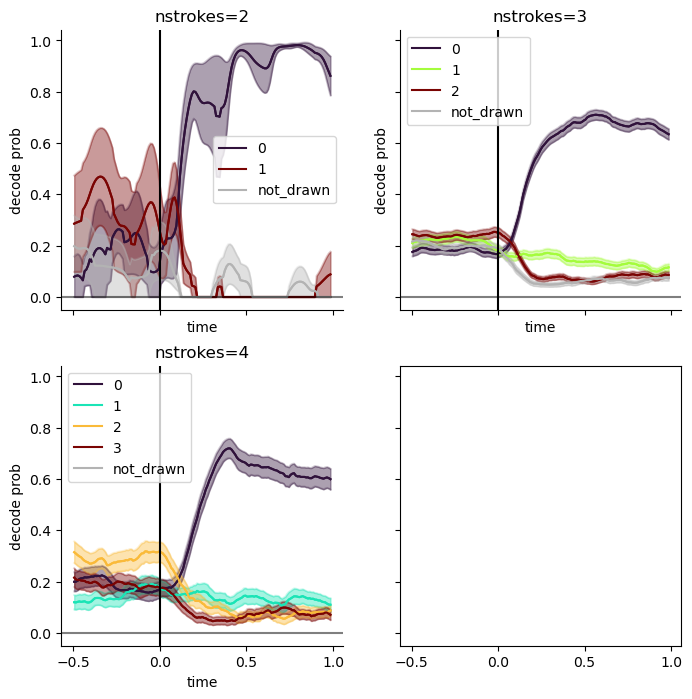

In [76]:

from pythonlib.tools.plottools import savefig

ylims = (-0.2, 0.8)
list_n_strokes = [2,3,4]
SIZE = 4

ncols = 2
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*SIZE, nrows*SIZE), sharex=True, sharey=True)

### FILTER
ct = 0
for nstrokes in list_n_strokes:

    ax = axes.flatten()[ct]
    # ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("decode prob")
    ax.set_title(f"nstrokes={nstrokes}")

    ct+=1

    filtdict = {"FEAT_num_strokes_task":[nstrokes], "FEAT_num_strokes_beh":[nstrokes]}

    pathis = PAprobs.slice_by_labels_filtdict(filtdict)
    if len(pathis.Trials)==0:
        print("SKIPPING!! this filtdict led to all data lost:")
        print(filtdict)
        continue

    Dc.timeseries_plot_by_shape_drawn_order(pathis, ax, ylims=None)

# savefig(fig, f"{savedir}/timecourse_mean-subplot={savesuffix}-ylims={ylims}.pdf")
# plt.close("all")


##### [Devo] Flexibly choose which decoders to plot, and color accordingly

In [59]:
import numpy as np

In [60]:
# Extract probs

# (1) for each trial, get the new ordering of labels
dflab = PAtest.Xlabels["trials"]
list_labelidx_ordered =[]
for i, row in dflab.iterrows():
    labelidx_ordered = [0,1,2] ## ... Get its order
    list_labelidx_ordered.append(labelidx_ordered)

# (2) Get raw probs matrix with new ordering.
probs_mat_all_reordered = Dc.timeseries_extract_by_inputed_reorder(PAprobs, list_labelidx_ordered, append_leftover_indices=True)

print(probs_mat_all_reordered.shape)

(463, 149, 4)


PLOTTING... ()  (463, 149, 4)


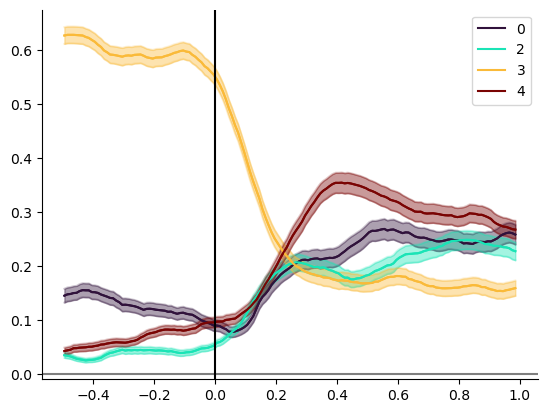

In [63]:
times = PAprobs.Times
labels = [0,2,3,4]
MAP_INDEX_TO_COL = None
fig, ax = plt.subplots()
Dc._timeseries_plot_by_shape_drawn_order(probs_mat_all_reordered, times, labels, MAP_INDEX_TO_COL, ax)

In [ ]:

# Reorder each trial 

### Plot timecourses for specific slices of data trials (i.e., filtdict)

In [ ]:
### Get timecourses
# Get all test trials, just correct ones
dflab = PAtest.Xlabels["trials"]

# Take a subset
indtrials = list(range(len(dflab)))
PAprobsOrig, probs_mat_all, times, labels = Dc.timeseries_score_wrapper(PAtest, twind_test, indtrials)


In [ ]:
# Separate plots for deterministic and ambiguous locations

list_taskconfig_loc_ambiguous = [
    ((-1, 0), (-1, 1), (1, 1)),
]


In [ ]:
from pythonlib.tools.plottools import savefig
from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import probs_timecourse_normalize

SAVEDIR = "/tmp/pig_timecourses"
os.makedirs(SAVEDIR, exist_ok=True)

In [ ]:
LIST_PARAMS = []
LIST_SAVESUFF = []

list_title_filtdict = [
    ("all", None),
]
savesuffix = "all"
LIST_PARAMS.append(list_title_filtdict)
LIST_SAVESUFF.append(savesuffix)


list_title_filtdict = [
    ("ambiguous_taskconfig_loc", {"taskconfig_loc":list_taskconfig_loc_ambiguous}),
    ("deterministic", {"taskconfig_loc":[x for x in dflab["taskconfig_loc"].unique().tolist() if x!=((-1, 0), (-1, 1), (1, 1))]}),
]
savesuffix = "syntax_concrete_idx1-1"
LIST_PARAMS.append(list_title_filtdict)
LIST_SAVESUFF.append(savesuffix)


for NORM_METHOD in ["minus_not_visible_and_base", None, "minus_base_twind"]:
    if NORM_METHOD is not None:
        PAprobs = probs_timecourse_normalize(Dc, PAprobsOrig, NORM_METHOD, None)
        YLIMS = (-0.25, 0.8)
    else:
        PAprobs = PAprobsOrig.copy()
        YLIMS = (0, 0.6)

    savedir = f"{SAVEDIR}/norm={NORM_METHOD}"
    os.makedirs(savedir, exist_ok=True)

    for ylims in [None, YLIMS]:
        list_n_strokes = [2,3, 4]
        SIZE = 4
        for list_title_filtdict, savesuffix in zip(LIST_PARAMS, LIST_SAVESUFF):
            ncols = len(list_title_filtdict)
            nrows = len(list_n_strokes)
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*SIZE, nrows*SIZE), sharex=True, sharey=True)

            ### FILTER
            ct = 0
            for nstrokes in list_n_strokes:
                for title, filtdict in list_title_filtdict:
                    ax = axes.flatten()[ct]
                    # ax.set_title(title)
                    ax.set_title(f"nstrokes={nstrokes}--{title}")

                    ct+=1

                    filtdict_this = {"FEAT_num_strokes_task":[nstrokes], "FEAT_num_strokes_beh":[nstrokes]}
                    if filtdict is not None:
                        for k, v in filtdict.items():
                            filtdict_this[k] = v

                    pathis = PAprobs.slice_by_labels_filtdict(filtdict_this)
                    if len(pathis.Trials)==0:
                        print("SKIPPING!! this filtdict led to all data lost:")
                        print(filtdict_this)
                        continue

                    Dc.timeseries_plot_by_shape_drawn_order(pathis, ax, ylims=ylims)

            savefig(fig, f"{savedir}/timecourse_mean-subplot={savesuffix}-ylims={ylims}.pdf")
            plt.close("all")
